### Libraries

In [ ]:
# !pip install torch torchvision
# !pip install transformers datasets
# !pip install transformers[torch]

In [1]:
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from PIL import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-12-10 17:35:01.478346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 17:35:02.045044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading the Data

In [2]:
trainds, testds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']
trainds, valds, testds

(Dataset({
     features: ['img', 'label'],
     num_rows: 4500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 1000
 }))

In [4]:
trainds.features, trainds.num_rows, trainds[0]

({'img': Image(decode=True, id=None),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)},
 4500,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 0})

In [3]:
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
itos, stoi

({0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

airplane


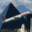

In [6]:
img, lab = trainds[0]['img'], itos[trainds[0]['label']]
print(lab)
img

In [7]:
print(img.size)

(32, 32)


### Preprocessing Data

In [4]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std
size = processor.size
size

{'height': 224, 'width': 224}

In [5]:
norm = Normalize(mean=mu, std=sigma)

_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
])

def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

In [6]:
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

In [11]:
trainds[0].keys()

dict_keys(['img', 'label', 'pixels'])

torch.Size([3, 224, 224])
tensor(-1.) tensor(0.9059)
tensor(0.) tensor(0.9529)


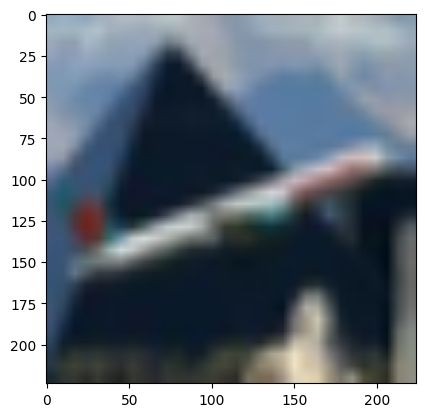

In [12]:
ex = trainds[0]['pixels']
print(ex.shape)
print(torch.min(ex), torch.max(ex))
ex = (ex+1)/2
print(torch.min(ex), torch.max(ex))

exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

### Model - Fine Tuning

In [7]:
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier) #The google/vit-base-patch16-224 model is originally fine tuned on imagenet-1K with 1000 output classes

# print(model.config)
#To use Cifar-10, it needs to be fine tuned again with 10 output classes
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10,  ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


### Hugging Face Trainer

In [8]:
!pip show accelerate

Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /home/chaowei/prj/myenv/lib/python3.8/site-packages
Requires: psutil, torch, packaging, pyyaml, huggingface-hub, safetensors, numpy
Required-by: 


In [13]:
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args, 
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Training the model for fine tuning

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.129892,0.974000
2,No log,0.089804,0.978000
3,0.297200,0.084143,0.978000


TrainOutput(global_step=675, training_loss=0.22329048227380824, metrics={'train_runtime': 1357.9833, 'train_samples_per_second': 9.941, 'train_steps_per_second': 0.497, 'total_flos': 1.046216869705728e+18, 'train_loss': 0.22329048227380824, 'epoch': 3.0})

### Evaluation

In [23]:
outputs = trainer.predict(testds)
print(outputs.metrics)

{'test_loss': 0.07223748415708542, 'test_accuracy': 0.973, 'test_runtime': 28.5169, 'test_samples_per_second': 35.067, 'test_steps_per_second': 4.383}


In [30]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

('cat', 'cat')

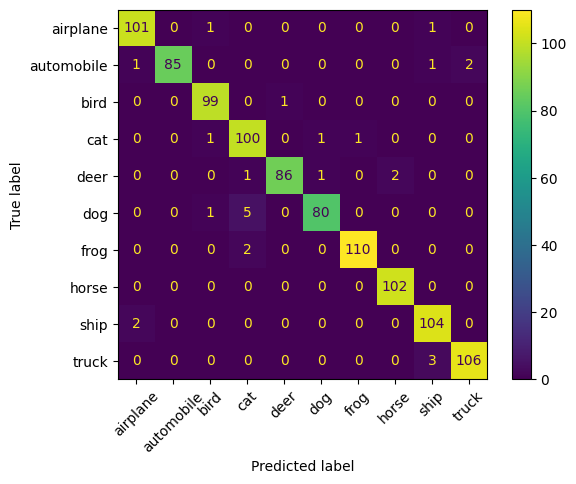

In [31]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)